In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scipy

In [6]:
orb = pd.read_json('ODR_SpaceFence_SBModel/unclass_25984_ORBCOMM_FM_36_1999-065E_d70_11Mar2023.json')
c_2499 = pd.read_json('ODR_SpaceFence_SBModel/unclass_39765_COSMOS_2499_2014-028E_d4_4Jan2023.json')
h_ra = pd.read_json('ODR_SpaceFence_SBModel/unclass_43674_H-RA_debris_2018-084D_d184_3Jul2022.json')
cz_6a = pd.read_json('ODR_SpaceFence_SBModel/unclass_54236_CZ-6A_RB_2022-151B_d316_12Nov2022.json')
c_13552 = pd.read_json('ODR_SpaceFence_SBModel/unclass_COSMOS_13552_SF.json')

orb['Name'] = 'ORBCOMM FM-36'
c_2499['Name'] = 'COSMOS 2499'
h_ra['Name'] = 'H-IIA RB'
cz_6a['Name'] = 'CZ-6A RB'
c_13552['Name'] = 'COSMOS 1408'

dfs = [orb, c_2499, h_ra, cz_6a, c_13552]

1.8999037105401384


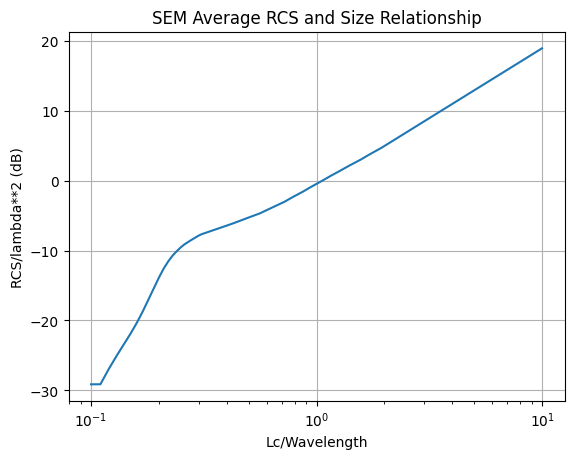

In [9]:
x_list = np.arange(0.1, 10, 0.01)
z_list = []
# taken from Haystack Ultra Wideband Satellite Imaging Radar (HUSIR) Page 35
xp = [0.10997, 0.11685, 0.12444, 0.13302, 0.14256, 0.15256, 0.16220,
    0.17138, 0.18039, 0.18982, 0.20014, 0.21237, 0.22902, 0.25574, 
    0.30537, 0.42028, 0.56287, 0.71108, 0.86714, 1.0529, 1.2790, 1.5661, 1.8975]
zp = [0.001220, 0.001735, 0.002468, 0.003511, 0.004993, 0.007102, 
    0.01010, 0.01437, 0.02044, 0.02907, 0.04135, 0.05881, 0.08365, 
    0.1190, 0.1692, 0.2407, 0.3424, 0.4870, 0.6927, 0.9852, 1.401, 1.993, 2.835]

print(np.sqrt(4*2.835/np.pi))
for x in x_list:
    if x > 1.899:
        z = x**2/4*np.pi
    elif x < 0.0003:
        z = ((x**6)/4)*(9*np.pi)**5
    else:
        z = np.interp(x, xp, zp)
    z_list.append(np.log10(z)*10)

plt.semilogx(x_list, z_list)
plt.title("SEM Average RCS and Size Relationship")
plt.xlabel("Lc/Wavelength")
plt.ylabel("RCS/lambda**2 (dB)")
plt.grid()

55
1
54
1
54
2
53
1
54


/home/capitalts/anaconda3/envs/SBM/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6895: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


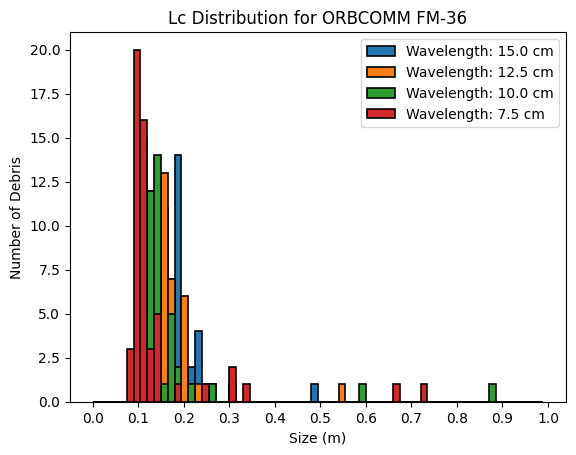

150
0
150
0
150
0
150
0
150


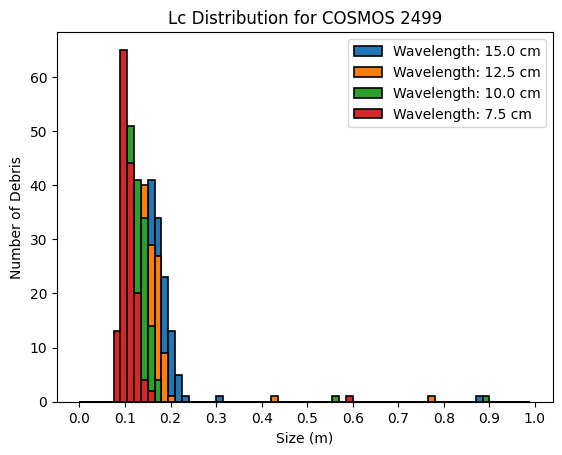

69
1
68
1
68
1
68
1
68


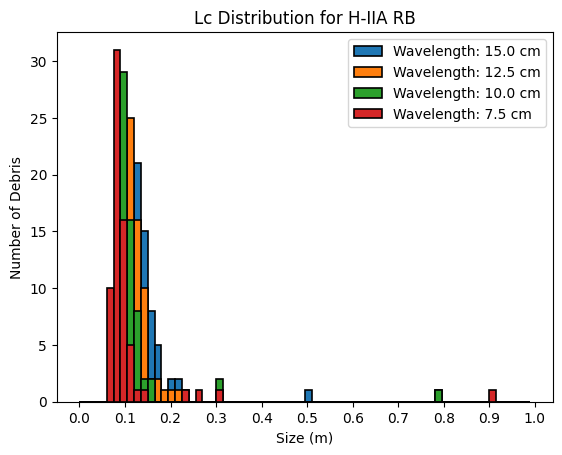

238
11
227
10
228
11
227
11
227


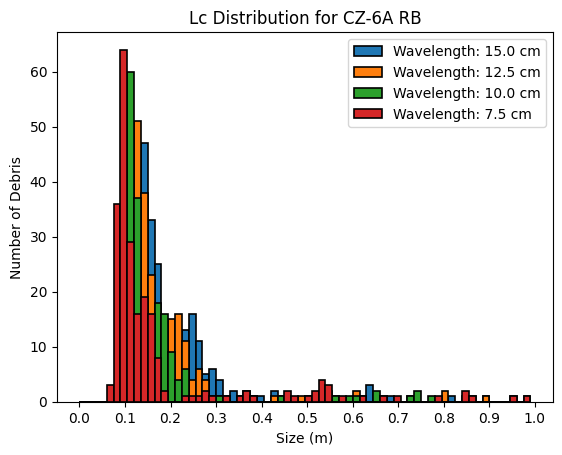

1665
5
1660
5
1660
6
1659
7
1658


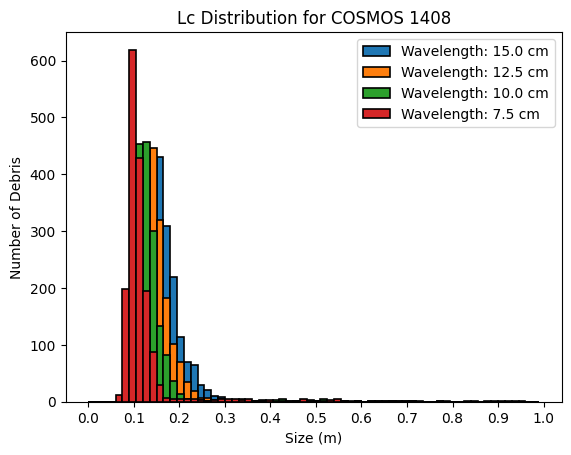

In [ ]:
lc = {}
# taken from Haystack Ultra Wideband Satellite Imaging Radar (HUSIR) Page 35
xp = [0.10997, 0.11685, 0.12444, 0.13302, 0.14256, 0.15256, 0.16220,
    0.17138, 0.18039, 0.18982, 0.20014, 0.21237, 0.22902, 0.25574, 
    0.30537, 0.42028, 0.56287, 0.71108, 0.86714, 1.0529, 1.2790, 1.5661, 1.8975]
zp = [0.001220, 0.001735, 0.002468, 0.003511, 0.004993, 0.007102, 
    0.01010, 0.01437, 0.02044, 0.02907, 0.04135, 0.05881, 0.08365, 
    0.1190, 0.1692, 0.2407, 0.3424, 0.4870, 0.6927, 0.9852, 1.401, 1.993, 2.835]
for df in dfs:
    lambdas = np.arange(7.5, 15.5, 2.5)#cm
    lc[df['rsoNumber'][0]] = {str(lam): np.array([]) for lam in lambdas}
    paramMap = pd.json_normalize(df['paramMap'])
    metadata = pd.json_normalize(df['metadata'])
    print(len(df['obsSetUUID'].unique()))
    for lam in lambdas:
        x_list = []
        z_list = []
        RCS_list = []
        
        for obsSet in df['obsSetUUID'].unique():
            rso_number = df[df['obsSetUUID'] == obsSet]
            paramMap = pd.json_normalize(rso_number['paramMap'])
            RCS_1 = paramMap['map.RCS_1'] #Orthogonal Polarization
            RCS_2 = paramMap['map.RCS_2'] #Primary Polarization

            RCS = np.concatenate((RCS_1, RCS_2))

            RCS_list.append(np.mean(RCS))
            xs = []
            for rcs in RCS:
                z = 10**(rcs/10)/lam**2

                
                #Opitcal Regime (RCS >> wavelength), SSEM paper uses z > 2.835, HUSIR paper > 5
                if z > 2.835:
                    
                    x = np.sqrt(4*z/np.pi)
                #Rayleigh Regime (RCS << wavelength), SSEM paper uses z < 0.00122, HUSIR paper < 0.03
                elif z < 0.00122:
                    x = (4*z/((9*np.pi)**5))**(1/6)
                #Mie Regime (RCS ~= wavelength), Interpolation using xp and zp
                else:
                    x = np.interp(z, zp, xp)
                xs.append(x)
            #x = size/lambda, to find size, multiply by lambda
            x = np.mean(xs)
            
            lc[df['rsoNumber'][0]][str(lam)] = np.append(lc[df['rsoNumber'][0]][str(lam)], x*lam)
            x_list.append(x)
            z_list.append(np.log10(z*10))

    plt.show()

   # plot histogram of sizes for each rso number
    for lam in lambdas[::-1]:
        bins = np.arange(0, 1, 0.015)
        bins = np.append(bins, np.inf)

        plt.hist(lc[df['rsoNumber'][0]][str(lam)], bins=bins, edgecolor='black', linewidth=1.2, label='Wavelength: ' + str(lam) + " cm")
        
    plt.title("Lc Distribution for " + df['Name'][0])
    plt.xlabel("Size (m)")
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.ylabel("Number of Debris")
    plt.legend()
    plt.show()

    print("Average Lc for Debris", df['rsoNumber'][0], "is", np.mean(lc[df['rsoNumber'][0]]), "cm")
    print("Standard deviation for Debris", df['rsoNumber'][0], "is", np.std(lc[df['rsoNumber'][0]]), "cm")





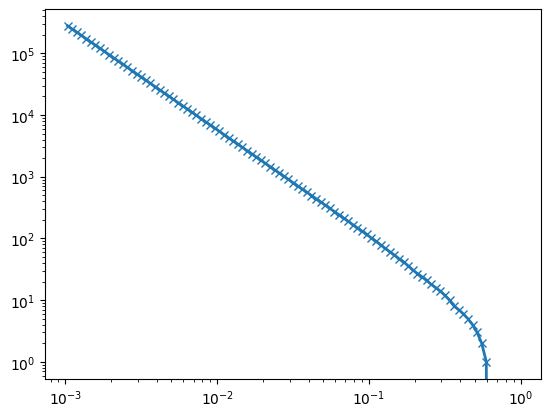

In [267]:
def SBM_Col(mass_primary, v_rel, p1_radius, mass_secondary = None):
    '''
    Calculates the LC comulative distribtion using the nasa standard breakup model
    
    Inputs:
    mass_primary: mass of the primary object in kg
    mass_secondary: mass of the secondary object in kg
    v_rel: relative velocity between the two objects in km/s

    Outputs:
    N: number of debris objects with characteristic length scale Lc [1xn array]
    '''



    p1_mass = mass_primary
    p2_mass = mass_secondary

    # Calculate catastrophic ratio
    catastrophRatio = (p2_mass * (v_rel * 1000)**2) / (2 * p1_mass*1000)  # J/g = kg*m^2/s^2 / g

    if catastrophRatio < 40:
        M = p2_mass * v_rel**2  # correction from ODQN [kg*km^2/s^2]
        category = "Non-Catastrophic"
    else:
        M = p1_mass + p2_mass
        category = "Catastrophic"

    # Define LB here, for example LB = 0.01
    LB = 0.001
    num = np.floor(0.1 * M ** (0.75) * LB**(-1.71) - 0.1 * M**(0.75) * np.min([1,2*p1_radius])**(-1.71))
    dd_edges = np.logspace(np.log10(LB), np.log10(min(1, 2 * p1_radius)), 100)

    # dd_edges = np.logspace(np.log10(LB), np.log10(5))
    log10_dd = np.log10(dd_edges)
    dd_means = 10**(log10_dd[:-1] + np.diff(log10_dd) / 2)

    nddcdf = 0.1 * M**(0.75) * dd_edges**(-1.71)
    ndd = np.maximum(0, -np.diff(nddcdf))
    floor_ndd = np.floor(ndd)
    rand_sampling = np.random.rand(len(ndd))
    add_sampling = (rand_sampling > (1 - (ndd - floor_ndd))).astype(int)
    d_pdf = np.repeat(dd_means, (floor_ndd + add_sampling).astype(int))
    
    # Assuming d_pdf is a numpy array of probabilities and num is the desired sample size
    # d = np.random.choice(len(d_pdf), size=int(np.ceil(num)), p=d_pdf)

    # Do not limit number of fragments to be equal to 'num'
    d = np.random.choice(d_pdf, size=len(d_pdf), replace=False)
    # cum_d = np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0])))
    return dd_means, dd_edges, d, category, M

mass_primary = 56 #kg
mass_secondary = 0.57 #kg
v_rel = 6.8 #km/s
p1_radius = 0.60 #m
dd_means, dd_edges, d, _, _= SBM_Col(mass_primary, v_rel, p1_radius, mass_secondary)
plt.loglog(dd_means, np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0]))), '-x', linewidth=2, label = "SBM")


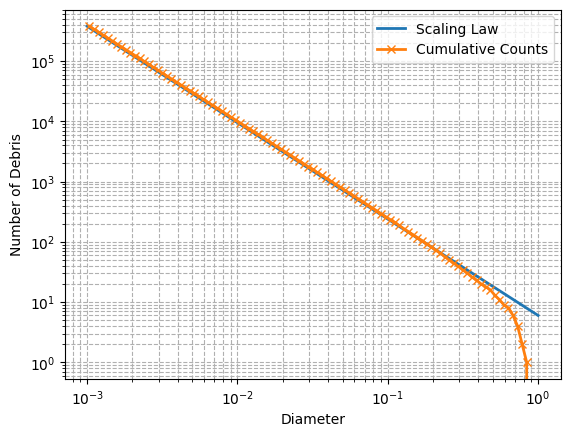

In [268]:
def SBM_exp(scale, mass, radius):
    '''
    Calculates the LC comulative distribtion using the nasa standard breakup model due to an explosion
    
    Inputs:
    scale: scaling factor for the number of debris objects
    primary: mass of the primary object in kg
    radius: radius of the primary object in m

    Outputs:
    dd_means: mean of the debris size distribution
    dd_edges: edges of the debris size distribution
    d: debris size distribution
    '''
    LB = 0.001

    # Assuming p1_in is already defined as a list or NumPy array

    # Set scaling factor 's' based on p1_objclass with a dictionary or if-else block
    # For this example, I'll assume a default value of 1
    cs = scale

    # Calculate number of debris
    num = int(np.floor(6 * cs * LB**(-1.6) - 6 * cs * min([1, 2*radius])**(-1.6)))

    # Create PDF and sample 'num' selections
    dd_edges = np.logspace(np.log10(LB), np.log10(min([1, 2*radius])), 100)
    log10_dd = np.log10(dd_edges)
    dd_means = 10**(log10_dd[:-1] + np.diff(log10_dd)/2)

    nddcdf = 6 * cs * dd_edges**-1.6
    ndd = np.maximum(0, -np.diff(nddcdf))
    floor_ndd = np.floor(ndd)
    rand_sampling = np.random.rand(len(ndd))
    add_sampling = (rand_sampling > (1 - (ndd - floor_ndd))).astype(int)
    d_pdf = np.repeat(dd_means, (floor_ndd + add_sampling).astype(int))

    # Shuffle the d_pdf and do not limit the number of fragments
    d = np.random.permutation(d_pdf)

    # To limit the number of fragments to be equal to 'num', 
    # uncomment the following line and comment out the previous one
    # d = np.random.choice(d_pdf, size=int(np.ceil(num)), replace=False)
    return dd_means, dd_edges, d

mass = 1400 #kg
radius = 2.5 #m
dd_means, dd_edges, d = SBM_exp(1.0, mass, radius)

# First plot
plt.loglog(dd_edges, 6 * dd_edges**-1.6, linewidth=2, label='Scaling Law')

# Calculate the histogram of `d` based on `dd_edges`
hist_counts, _ = np.histogram(d, bins=dd_edges)

# Cumulative sum of the flipped histogram counts
cumulative_counts = np.flip(np.cumsum(np.flip(hist_counts)))

# Midpoints for log-log plot based on dd_means
log_midpoints = dd_means

# Second plot with flipped cumulative sum against midpoints
plt.loglog(log_midpoints, cumulative_counts, '-x', linewidth=2, label='Cumulative Counts')

# Additional plot formatting, if necessary
plt.xlabel('Diameter')
plt.ylabel('Number of Debris')
plt.legend()
plt.grid(True, which="both", ls="--")

# Show the plot
plt.show()


In [305]:

from matplotlib.ticker import Formatter

class CustomFormatter(Formatter):
    def __call__(self, x, pos=None):
        # This function takes the tick value and position
        # and returns the string label for that tick.
        if x < 0.01:
            return f'{x:.3f}'  # Fewer decimal places as we approach 1
        elif x < 0.1:
            return f'{x:.2f}'
        elif x < 1:
            return f'{x:.1f}'  # No decimal places at or beyond 1
        else:
            return f'{x:.0f}'





def plot_SBM_range(dfs, primary_masses, secondary_masses, primary_radius, v_rels):
    """
    Plot SBM against debris size distribution with range of secondary masses and scaling for explosion

    Inputs:
    dfs: list of dataframes
    primary_masses: list of primary masses in kg
    secondary_masses: list of secondary masses in kg
    primary_radius: list of primary radius in m
    v_rels: list of relative velocities in km/s

    Outputs:

    """
    mass = {df['rsoNumber'][0] : np.array([primary_masses[i], secondary_masses[i][0], secondary_masses[i][1]]) for i, df in enumerate(dfs)}
    radius = {df['rsoNumber'][0] : primary_radius[i] for i, df in enumerate(dfs)}
    v_rel = {df['rsoNumber'][0] : v_rels[i] for i, df in enumerate(dfs)}
    for df in dfs:

        if mass[df['rsoNumber'][0]][1] != None:

            
            sec_mass_range = np.linspace(mass[df['rsoNumber'][0]][1], mass[df['rsoNumber'][0]][2], 100)
            cat = False
            non_cat = False
            for sec_mass in sec_mass_range:
                dd_means, dd_edges, d, category, M = SBM_Col(mass[df['rsoNumber'][0]][0], v_rel[df['rsoNumber'][0]], radius[df['rsoNumber'][0]], sec_mass)
                if category == "Catastrophic":
                    if cat == False:
                        cat = True
                        plt.plot(dd_means, np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0]))), 'lightgreen', alpha=1, linewidth=1, label = "SBM " + category)
                    else:
                        plt.plot(dd_means, np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0]))), 'lightgreen', alpha=0.1, linewidth=10)
                else:
                    if non_cat == False:
                        non_cat = True
                        plt.loglog(dd_means, np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0]))), 'lightskyblue', alpha=1, linewidth=1, label = "SBM " + category)
                    else:
                        plt.loglog(dd_means, np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0]))), 'lightskyblue', alpha=0.1, linewidth=10)
            # plt.loglog(dd_edges, (0.1 * M**(0.75) * dd_edges**(-1.71)), linewidth=2, label='Scaling Law')

            
        else:
            category = "Explosion"
            exp = False
            for scale in np.linspace(0.5, 3, 100):
                dd_means, dd_edges, d = SBM_exp(scale, mass[df['rsoNumber'][0]][0], radius[df['rsoNumber'][0]])
                if exp == False:
                    exp = True
                    
                    plt.loglog(dd_means, np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0]))), 'bisque', alpha=1, linewidth=1, label = "SBM " + category)
                else:
                    plt.loglog(dd_means, np.flip(np.cumsum(np.flip(np.histogram(d, dd_edges)[0]))), 'bisque', alpha=0.1, linewidth=10)
            
            # plt.loglog(dd_edges, 6 * dd_edges**-1.6, linewidth=2, label='Scaling Law')

        # First plo
        print("d", len(np.where((d<1) & (d>0.1))[0]))
        # print("d>1", len(np.where(d>1)[0]))
        print(max(d))
        


        #power law fit
        for lam in lambdas[::-1]:
            x = np.sort(lc[df['rsoNumber'][0]][str(lam)])[::-1]
            # x = x[x<1]
            y = np.arange(1, len(x)+1)
            plt.loglog(x, y, label = "Wavelength " + str(lam) + " cm")


        plt.xlim([0.001, 1])
        plt.ylim([1, 1e7])
        plt.gca().set_xticks([0.001, 0.01, 0.1, 1])
        plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())
        plt.gca().xaxis.set_major_formatter(CustomFormatter())
        plt.gca().set_xscale('log')
        plt.gca().set_yscale('log')
        plt.title("Cumulative Distribution of Lc for " + df['Name'][0])
        plt.xlabel("Size (m)")
        plt.ylabel("Cumulative Number")
        plt.legend()
        plt.grid(True, which="both", alpha=0.2)


        plt.show()

d 90
0.9657139052966048


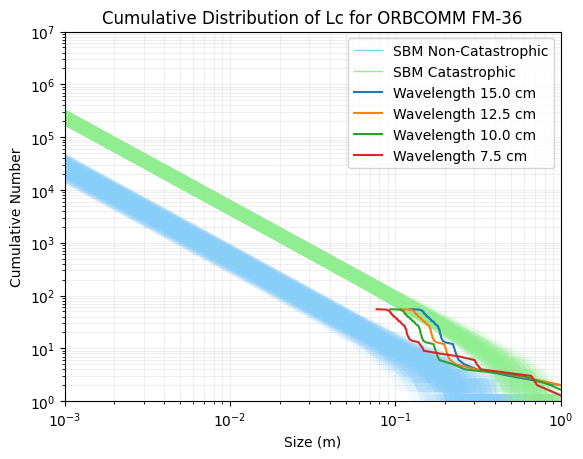

d 95
0.9657139052966048


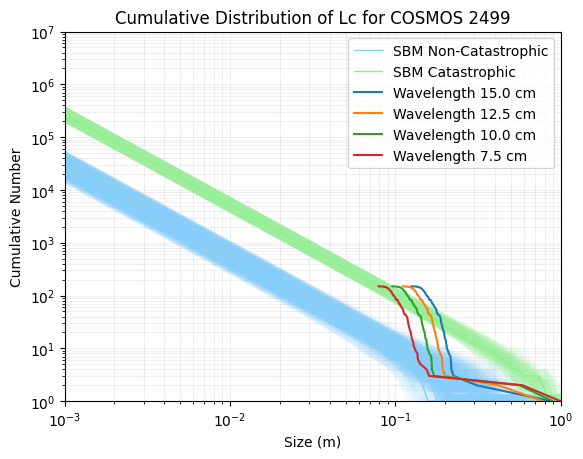

d 16
0.4180344961851453


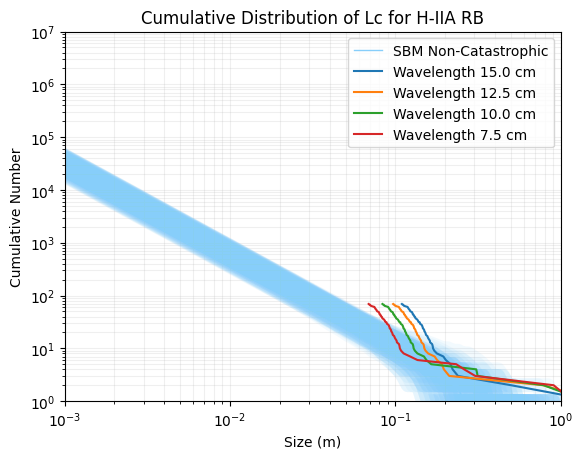

d 12
0.38986037025490716


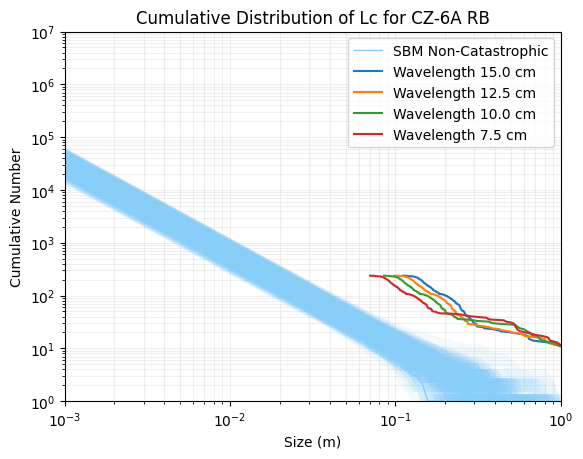

d 1397
0.9657139052966048


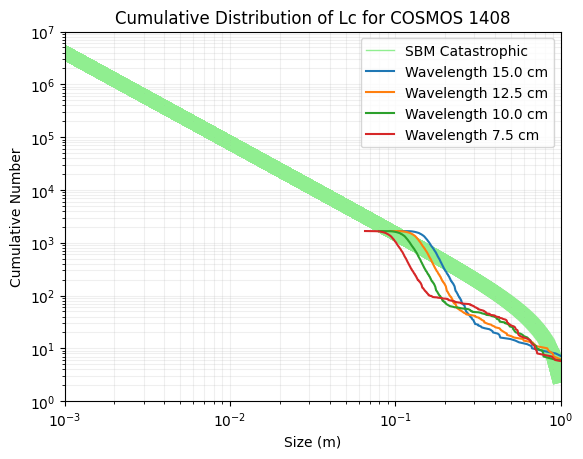

In [307]:
#plotting the SBM against SF data, treating unknowns as collisions
primary_masses = [42, 50, 1400, 952, 1750] # kg
# secondary_masses = [None, None, None, None, 0]
secondary_masses = [[0.011, 0.038], [0.011, 0.038], [0.011, 0.038], [0.011, 0.038], [63.5, 70]]

primary_radius = [3.5, 3.5, 8, 3, 2.5]
v_rels = [11, 11, 11, 11, 4.6]
plot_SBM_range(dfs, primary_masses, secondary_masses, primary_radius, v_rels)

d 693
0.9657139052966048


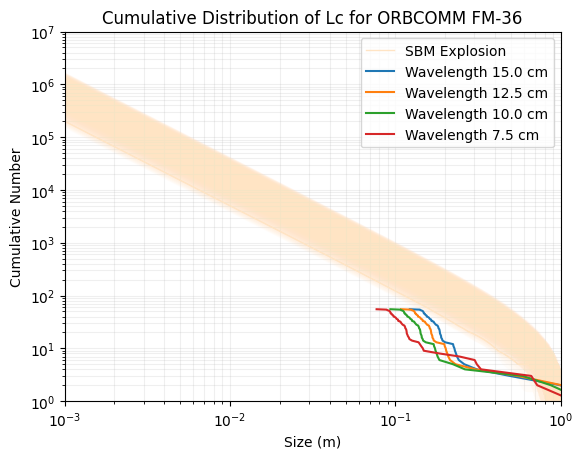

d 701
0.9657139052966048


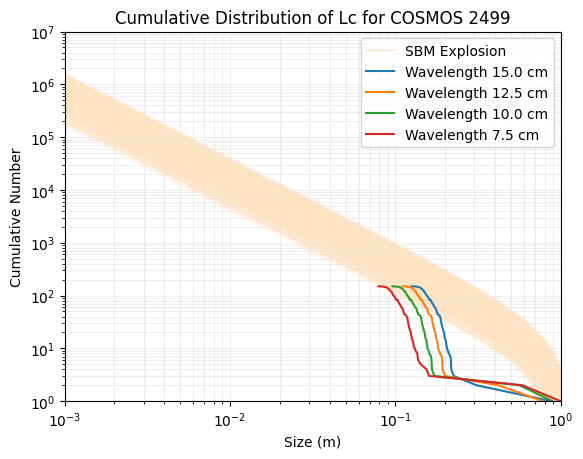

d 697
0.9657139052966048


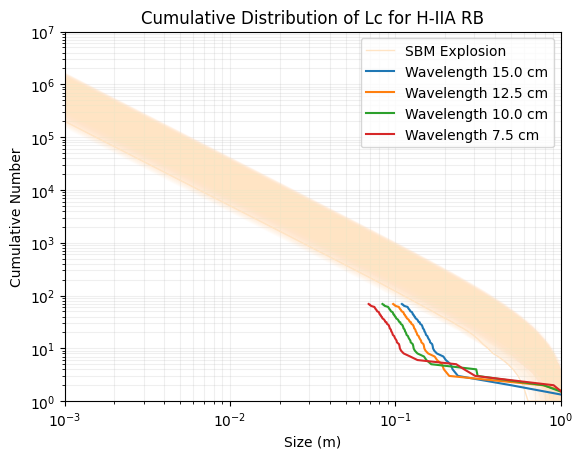

d 696
0.9657139052966048


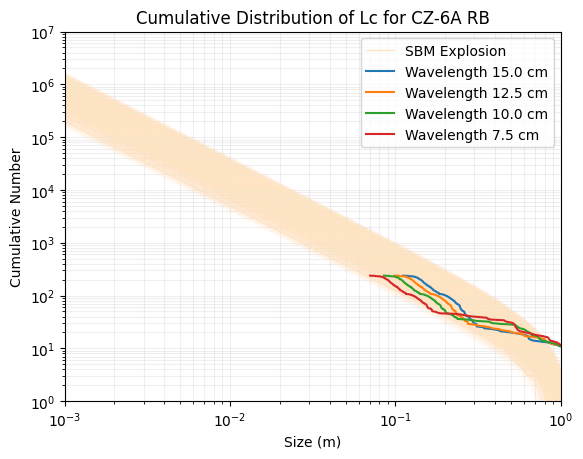

d 1402
0.9657139052966048


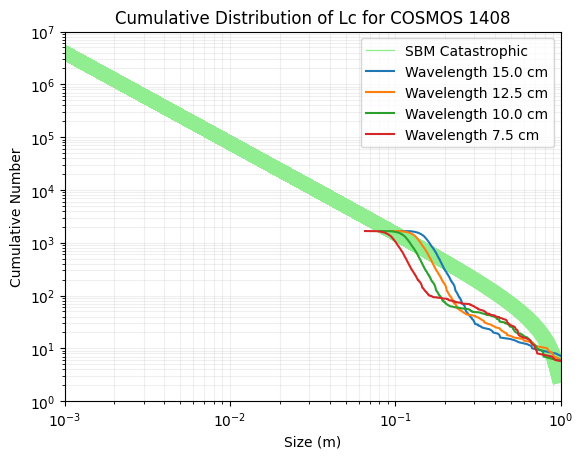

In [306]:
#plotting the SBM against SF data, treating unknowns as collisions
primary_masses = [42, 50, 1400, 952, 1750] # kg
# secondary_masses = [None, None, None, None, 0]
secondary_masses = [[None, None], [None, None], [None, None], [None, None], [63.5, 70]]

primary_radius = [3.5, 3.5, 8, 3, 2.5]
v_rels = [8, 7, 9, 0.5, 5]
plot_SBM_range(dfs, primary_masses, secondary_masses, primary_radius, v_rels)